In [339]:
from scipy.special import logsumexp
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline
from numba import jit

@jit('float64[:](int64,float64,float64,float64[:],float64[:],float64[:],float64[:],int64)',cache=True)
def log_trans_prob(i,N,s,FREQS,z_bins,z_logcdf,z_logsf,dt):
	# 1-generation transition prob based on Normal distn
	
	p = FREQS[i]
	lf = len(FREQS)
	logP = np.NINF * np.ones(lf)
	if p <= 0.0:
		logP[0] = 0
	elif p >= 1.0:
		logP[lf-1] = 0
		return logP
	else:
		plo = (FREQS[i]+FREQS[i-1])/2
		phi = (FREQS[i]+FREQS[i+1])/2
		if s != 0:
			mu = p - s*p*(1.0-p)/np.tanh(2*N*s*(1-p))*dt
			mulo = plo - s*plo*(1.0-plo)/np.tanh(2*N*s*(1-plo))*dt
			muhi = phi - s*phi*(1.0-phi)/np.tanh(2*N*s*(1-phi))*dt
		else:
			mu = p - p * 1/(2.0*N)*dt
			mulo = plo - plo * 1/(2.0*N)*dt
			muhi = phi - phi * 1/(2.0*N)*dt
		sigma = np.sqrt(p*(1.0-p)/(2.0*N)*dt)
		sigmalo = np.sqrt(plo*(1.0-plo)/(2.0*N)*dt)
		sigmahi = np.sqrt(phi*(1.0-phi)/(2.0*N)*dt)

                      
		pi0 = np.interp(np.array([(np.mean(FREQS[0])-mu)/sigma]),z_bins,z_logcdf)[0]
		pi1 = np.interp(np.array([(np.mean(FREQS[lf-1])-mu)/sigma]),z_bins,z_logsf)[0]
		pi0lo = np.interp(np.array([(FREQS[0]-mulo)/sigmalo]),z_bins,z_logcdf)[0]
		pi1lo = np.interp(np.array([(FREQS[lf-1]-mulo)/sigmalo]),z_bins,z_logsf)[0]
		pi0hi = np.interp(np.array([(FREQS[0]-muhi)/sigmahi]),z_bins,z_logcdf)[0]
		pi1hi = np.interp(np.array([(FREQS[lf-1]-muhi)/sigmahi]),z_bins,z_logsf)[0]
		#print(i,p,plo,phi,pi0lo,pi0hi,pi1lo,pi1hi)
		x = np.array([0.0,pi0,pi1])
		b = np.array([1.0,-1.0,-1.0])
		middleNorm = logsumexp(x,b=b)
        
		#x = np.array([0.0,pi0lo,pi1lo,0.0,pi0hi,pi1hi])
		#b = np.array([0.5,-0.5,-0.5,0.5,-0.5,-0.5])
		#middleNorm = logsumexp(x,b=b)

		middleP = np.zeros(lf-2)
		for j in range(1,lf-1):
			if j == 1:
				mlo = 0
			else:
				mlo = np.mean(np.array([FREQS[j],FREQS[j-1]]))
			if j == lf-2:
				mhi = 1
			else:
				mhi = np.mean(np.array([FREQS[j],FREQS[j+1]]))
                      
			l1 = np.interp(np.array([(mlo-mu)/sigma]),z_bins,z_logcdf)[0]
			l2 = np.interp(np.array([(mhi-mu)/sigma]),z_bins,z_logcdf)[0]
            
			#l1lo = np.interp(np.array([(mlo-mulo)/sigmalo]),z_bins,z_logcdf)[0]
			#l2lo = np.interp(np.array([(mhi-mulo)/sigmalo]),z_bins,z_logcdf)[0]

			#l1hi = np.interp(np.array([(mlo-muhi)/sigmahi]),z_bins,z_logcdf)[0]
			#l2hi = np.interp(np.array([(mhi-muhi)/sigmahi]),z_bins,z_logcdf)[0]
			#middleP[j-1] = logsumexp(np.array([l1lo,l2lo,l1hi,l2hi]),b=np.array([-0.5,0.5,-0.5,0.5]))
            
			middleP[j-1] = logsumexp(np.array([l1,l2]),b=np.array([-1.0,1.0]))

		#print(p,pi0,pi1,middleNorm)
		#logP[0] = logsumexp(np.array([pi0lo,pi1lo]),b=np.array([0.5,0.5]))
		logP[0] = pi0
		logP[1:lf-1] = middleP
		logP[lf-1] = pi1
		#logP[lf-1] = logsumexp(np.array([pi0hi,pi1hi]),b=np.array([0.5,0.5]))
	return logP

@jit('float64[:,:](float64,float64,float64[:],float64[:],float64[:],float64[:],int64)',cache=True)
def nstep_log_trans_prob(N,s,FREQS,z_bins,z_logcdf,z_logsf,dt):
	lf = len(FREQS)
	p1 = np.zeros((lf,lf))

	# load rows into p1
	for i in range(lf):
		row = log_trans_prob(i,N,s,FREQS,z_bins,z_logcdf,z_logsf,1.0)
		p1[i,:] = row

	# exponentiate matrix
	pn = log_matrix_power(p1,dt)
	return pn,p1

@jit('float64[:,:](float64[:,:],float64[:,:])',cache=True)
def log_prob_mat_mul(A,B):
    # multiplication of probability matrices in log space
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            C[i,j] = logsumexp( A[i,:] + B[:,j])
            if np.isnan(C[i,j]):
                C[i,j] = np.NINF
        ## special sauce...
        C[i,:] -= logsumexp(C[i,:])
    return C

@jit('float64[:,:](float64[:,:],int64)',cache=True)
def log_matrix_power(X,n):
    ## find log of exp(X)^n (pointwise exp()!) 
    
    assert(X.shape[0] == X.shape[1])
    
    b = 1
    k = 0
    # use 18 because you are fucked if you want trans
    # for dt > 2^18...
    matrices = np.zeros((X.shape[0],X.shape[1],18))
    matrices[:,:,0] = X
    
    while b < n:
        k += 1
        b += 2**k
        # square the last matrix
        matrices[:,:,k] = log_prob_mat_mul(matrices[:,:,k-1],
                                           matrices[:,:,k-1])
    
    leftover = n
    Y = np.NINF * np.ones((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        Y[i,i] = 0
        
    while leftover > 0:
        #print(leftover,k,2**k)
        if 2**k <= leftover:
            #print(2**k,'gens added')
            Y = log_prob_mat_mul(Y,matrices[:,:,k])
            leftover -= 2**k
        k -= 1
        
    return Y
        
            
        


    

num freqs = 100
drawing random freqs...
num freqs = 200
drawing random freqs...
num freqs = 300
drawing random freqs...
num freqs = 400
drawing random freqs...


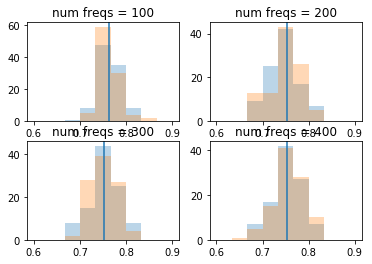

In [342]:
N = 10**4
s = 0.0
# read in global Phi(z) lookups
z_bins = np.genfromtxt('z_bins.txt')
z_logcdf = np.genfromtxt('z_logcdf.txt')
z_logsf = np.genfromtxt('z_logsf.txt')
n = 100

f,ax = plt.subplots(2,2)

for (axi,d) in enumerate([100,200,300,400]):
    print('num freqs = %d'%(d))
    a = 0.5
    b = a
    freqs = stats.beta.ppf(np.linspace(0,1,d),a,b)
    pn,p1 = nstep_log_trans_prob(N,s,freqs,z_bins,z_logcdf,z_logsf,n)

    i = np.digitize(0.75,freqs)

    f1 = []
    fn = []
    print('drawing random freqs...')
    for _ in range(100):
        #single step model
        trans1 = [stats.rv_discrete(name='custm', values=(list(range(d)), np.exp(p1[_,:]))) for _ in range(d)]
        i1 = [i]
        for t in range(n):
            i1 += [trans1[i1[-1]].rvs()]
        f1 += [i1[-1]]

        #n step model
        transn = stats.rv_discrete(name='custm', values=(list(range(d)), np.exp(pn[i,:]-logsumexp(pn[i,:]))))
        fn += [transn.rvs()]

    ax[axi//2][axi%2].hist(freqs[f1],bins=np.linspace(0.6,0.9,10),alpha=0.3)
    ax[axi//2][axi%2].hist(freqs[fn],bins=np.linspace(0.6,0.9,10),alpha=0.3)
    ax[axi//2][axi%2].axvline(freqs[i])
    ax[axi//2][axi%2].set_title('num freqs = %d'%(d))

In [270]:
N = 10**4
eps = 5/(2*N)


centers = [0,
           eps]
margins = [0,
           eps/2]
p = eps

while p < 1.0:
    margins += [p+np.sqrt(p*(1-p)/(20*N))]
    pprime = p+2*np.sqrt(p*(1-p)/(20*N))
    dprime = np.sqrt(pprime*(1-pprime)/(20*N))
    print(pprime,dprime)
    centers += [p+np.sqrt(p*(1-p)/(20*N))+dprime]
    p = centers[-1]
    


0.000320701838731 4.00374193138e-05
0.000406045943542 4.50489217537e-05
0.000501385854754 5.005669121e-05
0.000606718581417 5.50613509633e-05
0.000722041301773 6.00632981999e-05
0.000847351218819 6.50627856278e-05
0.000982645478747 7.00599702616e-05
0.00112792112253 7.50549437569e-05
0.00128317505595 8.00477519273e-05
0.00144840403041 8.50384076806e-05
0.00162360463024 9.00268998201e-05
0.00180877326411 9.50131991721e-05
0.00200390615905 9.99972629414e-05
0.00220899935627 0.000104979037863
0.00242404870813 0.000109958462521
0.00264904987591 0.000114935469083
0.00288399832824 0.000119909984611
0.0031288893399 0.000124881932068
0.00338371799086 0.000129851231096
0.00364847916571 0.00013481779863
0.00392316755308 0.00013978154938
0.00420777764531 0.000144742396218
0.00450230373817 0.000149700250488
0.00480673993069 0.000154655022258
0.005121080125 0.000159606620529
0.00544531802628 0.000164554953403
0.00577944714267 0.000169499928221
0.00612346078535 0.000174441451687
0.00647735206846 0.0

/Users/ajstern/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt


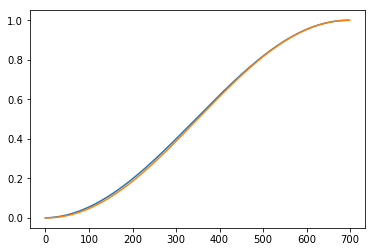

In [278]:
plt.plot(centers)
plt.plot(stats.beta.ppf(np.linspace(0,1,700),0.49,0.49))

In [325]:
def logsumexpa(x):
	max_x = np.max(x)
	x -= max_x
	sumexp = 0.0
	for xi in x:
		sumexp += np.exp(xi)
	val = max_x + np.log(sumexp)
	return val

def logsumexpb(x, b):
	max_x = np.max(x)
	x -= max_x
	sumexp = np.sum(b * np.exp(x))
	val = max_x + np.log(sumexp)
	return val

def logsumexpb(a,b):
    axis=0

    a_max = np.amax(a, axis=axis, keepdims=True)

    if a_max.ndim > 0:
        a_max[~np.isfinite(a_max)] = 0
    elif not np.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = np.asarray(b)
        tmp = b * np.exp(a - a_max)
    else:
        tmp = np.exp(a - a_max)

    # suppress warnings about log of zero
    s = np.sum(tmp, axis=axis)
    out = np.log(s)

    out += a_max
    return out[0]

def _logsumexpb(a,b):

    a_max = np.max(a)


    tmp = b * np.exp(a - a_max)


    s = np.sum(tmp)
    out = np.log(s)

    out += a_max
    return out[0]

def logsumexpa(a):
    a_max = np.max(a)

    tmp = np.exp(a - a_max)

    s = np.sum(tmp)
    out = np.log(s)

    out += a_max
    return out

x = np.linspace(-200,20,100)
b = np.linspace(-0.1,1,100)

#logsumexpb(x,b),logsumexp(x,b=b)
logsumexpa(x),logsumexp(x)

(20.114701813624865, 20.114701813624865)